In [21]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import time
from IPython.display import clear_output


In [22]:
classes = ['Гароу', 'Генос', 'Сайтама', 'Соник', 'Татсумаки', 'Фубуки']

In [23]:
for i, x in enumerate(classes):
    fld_path = os.path.join(f"train/{x}")
    for j in range(len(os.listdir(fld_path))): 
        img_path = os.path.join(fld_path, os.listdir(fld_path)[j])
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()

        time.sleep(0.2)
        clear_output()
        print(img_path)

train/Гароу\0e90e4a1421b55d8714cf49fc35f6282.jpg


KeyboardInterrupt: 

In [ ]:
count_classes = {x: len(os.listdir(os.path.join(f"train/{x}"))) for x in classes}
count_classes
plt.figure()
plt.bar(count_classes.keys(), count_classes.values())
plt.xlabel('Имя')
plt.ylabel('Кол-во')
plt.show()

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [70]:
# Параметры
BATCH_SIZE = 16  # Размер батча
NUM_EPOCHS = 10  # Количество эпох обучения
LEARNING_RATE = 0.0001  # Скорость обучения

# Определение путей к данным
train_dir = 'train'
test_dir = 'test'
train_csv_path = 'train.csv'
test_csv_path = 'test.csv'
submission_csv_path = 'submission.csv'

# Определение классов
classes = ['Гароу', 'Генос', 'Сайтама', 'Соник', 'Татсумаки', 'Фубуки']
mean, std, im_h, im_w = [0.56709862, 0.56204681, 0.54511651], [0.5521696, 0.54446173, 0.53878314], 128, 128

class AnimeDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path, encoding='utf-8')
        self.transform = transform
        self.classes = ['Гароу', 'Генос', 'Сайтама', 'Соник', 'Татсумаки', 'Фубуки']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['path']
        image = Image.open(path).convert('RGB')  # Load the image

        label = self.classes.index(self.df.iloc[idx]['class'])

        #img = np.asarray(image).astype('float32')
        #image = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((224, 224)).convert('RGB'))
        if self.transform:
            image = self.transform(image)
        return image, label 


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, ), std=(0.5, )),
    ])



In [71]:
train_data = AnimeDataset(train_csv_path, transform=transform)
test_data = AnimeDataset(test_csv_path, transform=transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,) 
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True)

In [72]:
image, label = train_data[0]
print(image.shape) 

torch.Size([3, 256, 256])


In [73]:
import torchvision.models as models
class Net(nn.Module):
    def __init__(self, classes): 
        super(Net, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT) 
        self.resnet.fc = nn.Identity() 
        for param in self.resnet.parameters():
            param.requires_grad = True 
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(self.resnet.layer4[2].conv3.out_channels, len(classes))

    def forward(self, x):
        x = self.resnet(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x



In [74]:
model = Net(classes)

torch.cuda.empty_cache()

criterition = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterition(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}")


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


In [75]:
import csv
model.eval()
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

test_path = "test/"
preds = []
images = []

for image_path in os.listdir(test_path):
    image = Image.open(os.path.join(test_path, image_path)).convert('RGB')
    image_tensor = preprocess(image)
    image_tensor = image_tensor.unsqueeze(0)
    images.append(image_path)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        preds.append(predicted.item())


labels = ['Гароу', 'Генос', 'Сайтама', 'Соник', 'Татсумаки', 'Фубуки']
with open('submissiom.csv', 'w', newline='', encoding="UTF-8") as csvfile:
    fieldnames = ['id', 'path', 'class']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(len(preds)):
        writer.writerow({'id': i, 'path': images[i], 'class': labels[preds[i]]})

In [ ]:
import csv
with open('submission.csv', 'w', newline='') as file:
writer = csv.writer(file)
writer.writerow(['id', 'class'])
for idx, prediction in enumerate(predictions):
writer.writerow([idx, train_data.classes[prediction]])

Original Image Shape: torch.Size([3, 564, 564])


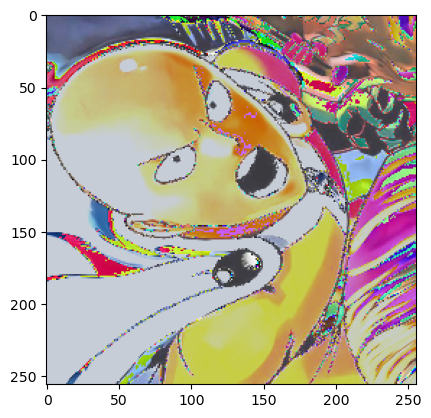

In [43]:
import torchvision.io as io
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np 

image_path = "train/Сайтама/6f0f1fe060f26c5dba3c3a4d59af7c5a.jpg" 

mean = [0.56709862, 0.56204681, 0.54511651]
std = [0.5521696, 0.54446173, 0.53878314]

transform = A.Compose([
    A.Resize(256, 256),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15),
    A.Normalize(mean=mean, std=std),
])

image = io.read_image(image_path) 
print(f"Original Image Shape: {image.shape}") 


image = image.numpy()
image = np.transpose(image)
augmented = transform(image=image)
image = augmented['image']

plt.imshow((image * 255).astype(np.uint8)) 
plt.show()